In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
tf.__version__
#Linking to Gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Work/Formatting_and_data/
#if you want to see the files in your directory use
%ls

Mounted at /content/drive
/content/drive/MyDrive/Work/Formatting_and_data
data.xlsx                image_at_epoch_0019.png  image_at_epoch_0039.png
GAN_diabetes.ipynb       image_at_epoch_0020.png  image_at_epoch_0040.png
image_at_epoch_0001.png  image_at_epoch_0021.png  image_at_epoch_0041.png
image_at_epoch_0002.png  image_at_epoch_0022.png  image_at_epoch_0042.png
image_at_epoch_0003.png  image_at_epoch_0023.png  image_at_epoch_0043.png
image_at_epoch_0004.png  image_at_epoch_0024.png  image_at_epoch_0044.png
image_at_epoch_0005.png  image_at_epoch_0025.png  image_at_epoch_0045.png
image_at_epoch_0006.png  image_at_epoch_0026.png  image_at_epoch_0046.png
image_at_epoch_0007.png  image_at_epoch_0027.png  image_at_epoch_0047.png
image_at_epoch_0008.png  image_at_epoch_0028.png  image_at_epoch_0048.png
image_at_epoch_0009.png  image_at_epoch_0029.png  image_at_epoch_0049.png
image_at_epoch_0010.png  image_at_epoch_0030.png  image_at_epoch_0050.png
image_at_epoch_0011.png  image_at_epoc

In [2]:
#double checking portions of code
data = pd.read_excel('data.xlsx')
labels = pd.read_excel('label.xlsx')
print(type(labels))
print(labels.shape)
data = data.iloc[:, 1:]
#removed first column because it was all NAN will FIX this later

<class 'pandas.core.frame.DataFrame'>
(364, 1)


In [3]:
# Before we figure out how to use NAN values, remove all rows in data and and labels
train_images = np.zeros((1,data.shape[1]))
train_labels = np.zeros((1,1))
isnan = data.isna().any(axis=1)
counter = 0
for i in isnan:
  if i == False:
    patient_to_append = data.iloc[counter, :];label_to_append = labels.iloc[counter]
    numpy_array = patient_to_append.to_numpy(); numpy_label = label_to_append.to_numpy();
    train_images = np.insert(train_images, -1, numpy_array, axis=0);
    train_labels = np.insert(train_labels, -1, numpy_label, axis=0);
  counter += 1
train_images = train_images[:-1]
train_labels = train_labels[:-1]
train_labels = train_labels.flatten()

In [67]:
# Normalize data, and keep track of data to un normalize it later as well
max_store = np.zeros((1,1))
for i in range(0,train_images.shape[1]):
  col_max = np.max(train_images[:,i])
  max_store = np.insert(max_store, -1, col_max, axis = 0)
for j in range(0,max_store.shape[0] - 1):
  train_images[:,j] = train_images[:,j]/max_store[j]
max_store = np.delete(max_store, -1)

In [68]:
print(train_images[1,:])
print(train_labels.shape)
print(max_store)

[[[0.66949153]
  [0.70833333]
  [0.36      ]
  [0.010921  ]
  [0.98039216]
  [0.97986111]]]
(349,)
[1.]


In [56]:
BATCH_SIZE = len(train_images)
train_images = train_images.reshape((-1, 1, 6, 1))
print(train_images.shape)
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE) #fix to include buffer size, not sure if it's needed but whatever
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) #fix to include buffer size, not sure if it's needed but whatever

(349, 1, 6, 1)


In [7]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(3 * 11 * 64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((3, 11, 64)))
    assert model.output_shape == (None, 3, 11, 64)

    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 3, 11, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2D(1, kernel_size=(3, 3), strides=(3, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 1, 6, 1)

    return model

(None, 1, 6, 1)


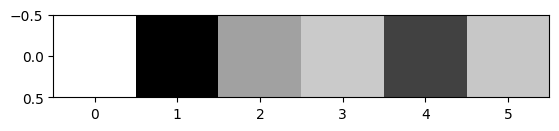

In [8]:
generator = make_generator_model()
print(generator.output_shape)
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
# def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same',
#                                      input_shape=[1, 6, 1]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

#     return model
# def make_discriminator_model():
#     model = tf.keras.Sequential()

#     # Assuming you want to process each time step independently
#     model.add(layers.Conv1D(32, 3, strides=1, padding='same', input_shape=(1, 6)))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Downsample
#     model.add(layers.Conv1D(16, 3, strides=2, padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Flatten and output
#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

#     return model
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Assuming you want to process each time step independently
    model.add(layers.Conv1D(32, 3, strides=1, padding='same', input_shape=(1,6,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample
    model.add(layers.Conv1D(16, 3, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [31]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
print(type(generated_image))
print(type(train_dataset))
result_array = np.concatenate([generated_image, generated_image, generated_image], axis=0)
decision = discriminator(result_array)
print(decision)

tf.Tensor([[-0.01865283]], shape=(1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
tf.Tensor(
[[-0.01865283]
 [-0.01865283]
 [-0.01865283]], shape=(3, 1), dtype=float32)


In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [43]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])#so change this later

In [44]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      images = tf.reshape(images, (-1, 1, 6, 1))
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [50]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  reshaped_predictions = np.squeeze(predictions, axis=(1, 3))
  print(reshaped_predictions.shape) #remove this line later
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') #Alter this to add the max from each column variable
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [51]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [52]:
regular_dataset = train_dataset.batch(256)  # Specify the batch size

# Get the element_spec
element_spec = regular_dataset.element_spec

# Print the element_spec
print(element_spec)

# If the element_spec is a TensorShape, you can get the dimensions
if isinstance(element_spec, tf.TensorShape):
    print("Shape of the dataset:", element_spec.as_list())

TensorSpec(shape=(None, 1, 6, 1), dtype=tf.float64, name=None)


(16, 6)


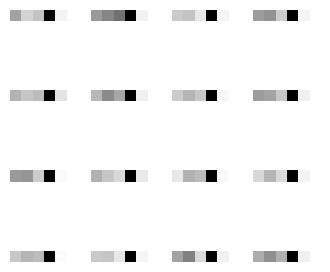

In [53]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

(300, 20)
